### Import of data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import copy
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

### Creation of class for parsing the rain data

In [ ]:
class nn_rain:
    def __init__(self, data):
        self._import_csv(data)

    def __getitem__(self, key):
        child = copy.copy(self)
        child.timestamp = self.timestamp[key]
        child.meas_period = self.meas_period[key]
        child.precipation = self.precipation[key]
        child.quality = self.quality[key]
        
        return child

    @staticmethod
    def _parse_date(date: list) -> float:
        tz_local = pytz.timezone("Australia/West")
        date = [int(i) for i in date]
        date_datetime = datetime(*date, tzinfo=tz_local)
        return date_datetime.timestamp()


    def _import_csv(self, path):
        date_idx = slice(2, 7)
        precip_idx = 7
        quality_idx = 8
        meas_period_idx = 9
        
        with open(path, "r") as f:
            data = f.readlines()
        self.header = data[0]
        self.station = int(data[1].split(",")[1])

        timestamp = []
        precip = []
        quality = []
        meas_period = []

        for line in data[1:]:
            try:
                # Parse data before appending
                ls = line.split(",")
                ts_val = self._parse_date(ls[date_idx])
                precip_val = float(ls[precip_idx])
                quality_val = ls[quality_idx]
                meas_period_val = int(ls[meas_period_idx])

                timestamp.append(ts_val)
                precip.append(precip_val)
                quality.append(quality_val)
                meas_period.append(meas_period_val)
            except ValueError as e:
                pass
                
        self.timestamp = np.array(timestamp)
        self.precipation = np.array(precip)
        self.quality = np.array(quality)
        self.meas_period = np.array(meas_period)

### Creation of data

In [6]:
nn = nn_rain("HD01D_Data_008297_9999999910795325.txt")

### Create running mean from data
Simplify to only use measurement durations of 1 minute

In [ ]:
mask = nn.meas_period == 1
val = nn.precipation[mask]

w = 6
rm_data = np.convolve(val,np.ones(w)/w, mode='valid')
rm_data = np.round(rm_data, 2)

val = rm_data

### Create Markov Model from data, including normalization

In [ ]:
def get_state(state_values, curr_value):
    return np.where(np.isclose(state_values, curr_value))[0][0]

states_values = np.unique(val)
print(states_values)
s_range = np.arange(len(states_values))
print(s_range)

state_counter = np.zeros((len(states_values),len(states_values)),dtype=np.float32)

prev_state = get_state(states_values, val[0])
for i in tqdm(range(1, len(val))):
    gcs = get_state(states_values, val[i])
    state_counter[prev_state, gcs] += 1
    prev_state = gcs

P = state_counter

P = state_counter
for i in range(len(states_values)):
    state_sum = np.sum(P[i,:])
    if state_sum > 0:
        P[i,:] = P[i,:] / state_sum
print(P)

[0.   0.03 0.07 0.1  0.13 0.17 0.2  0.23 0.27 0.3  0.33 0.37 0.4  0.43
 0.47 0.5  0.53 0.57 0.6  0.63 0.67 0.7  0.73 0.77 0.8  0.83 0.87 0.9
 0.93 0.97 1.   1.2  1.4  1.43 1.47 1.7  1.73 1.77 1.8  1.83 1.87 1.9
 1.93]
43
[0.   0.03 0.07 0.1  0.13 0.17 0.2  0.23 0.27 0.3  0.33 0.37 0.4  0.43
 0.47 0.5  0.53 0.57 0.6  0.63 0.67 0.7  0.73 0.77 0.8  0.83 0.87 0.9
 0.93 0.97 1.   1.2  1.4  1.43 1.47 1.7  1.73 1.77 1.8  1.83 1.87 1.9
 1.93]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


100%|██████████| 1636245/1636245 [00:43<00:00, 37411.95it/s]

[[9.9911910e-01 8.6239737e-04 1.4178084e-05 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.4621329e-01 7.8176200e-01 6.9036581e-02 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [4.3047783e-03 2.9832113e-01 5.7124406e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0000000e-01
  0.0000000e+00 0.0000000e+00]]


### Save models, plot as heatmap

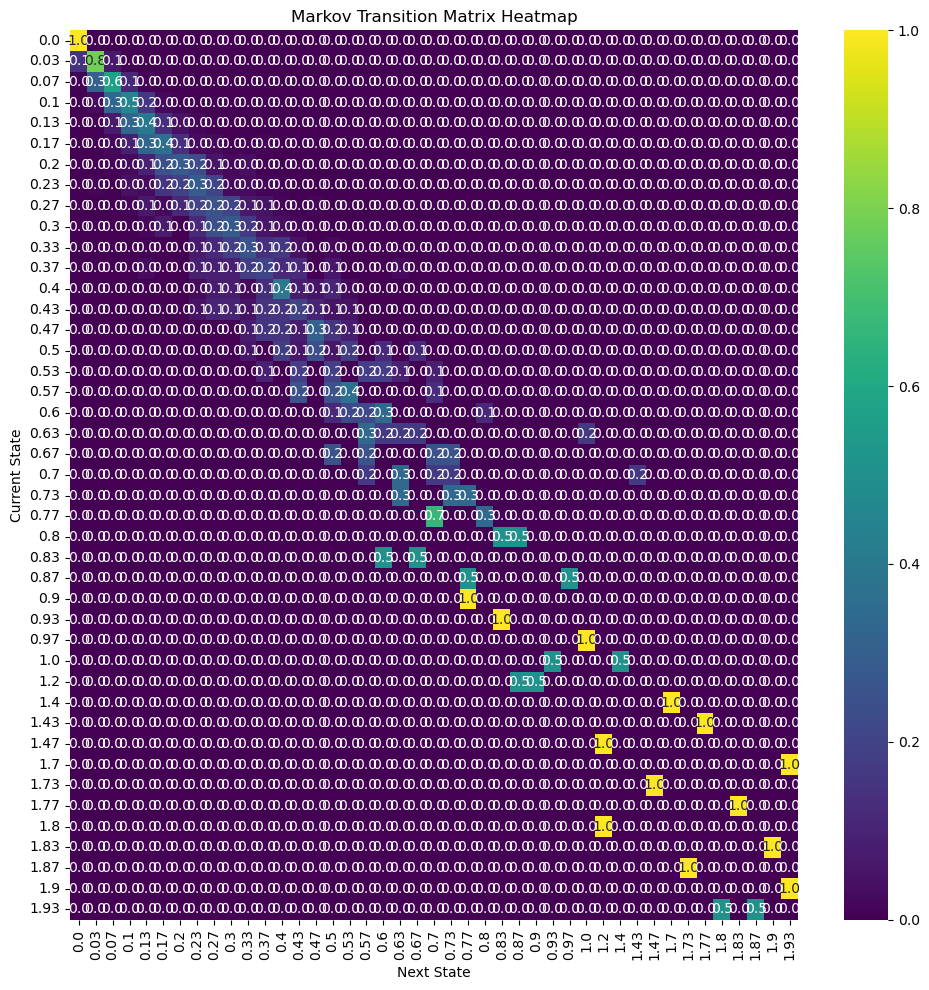

In [ ]:
np.save('nn_model_ma.npy', P)
np.save('nn_states_ma.npy', states_values)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(P, 
            annot=True, 
            fmt=".1f", 
            cmap="viridis", 
            xticklabels=states_values, 
            yticklabels=states_values,)

plt.xlabel("Next State")
plt.ylabel("Current State")
plt.title("Markov Transition Matrix Heatmap")
plt.tight_layout()
plt.show()

### Example of how to create rain data

In [12]:
states = np.zeros(len(val), dtype=np.int8)
fake_rain = np.zeros_like(val)
for i in tqdm(range(1, len(val))):
    prev_state = states[i-1]
    curr_state = np.random.choice(s_range,1,True,P[prev_state,:])
    states[i] = curr_state[0]
    fake_rain[i] = states_values[curr_state]


  0%|          | 0/1636245 [00:00<?, ?it/s]/tmp/ipykernel_837272/963340137.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fake_rain[i] = states_values[curr_state]
 35%|███▌      | 577026/1636245 [00:16<00:30, 34324.40it/s]


KeyboardInterrupt: 